# YouTube Trending Videos — Data Cleaning & Feature Engineering
This notebook prepares the dataset for analysis by:
- Removing duplicates
- Converting dates
- Adding title/tag features
- Creating engagement ratios
- Mapping categories
- Handling missing values
- Measuring trend longevity


Import Libraries

In [2]:
import pandas as pd
import json
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # ensures consistent results


Load Data

In [3]:
# Load CSV
df = pd.read_csv("Youtube_trendings/INvideos.csv", encoding="utf-8")

# Load category mapping
with open("Youtube_trendings/IN_category_id.json", "r") as f:
    categories = json.load(f)
category_map = {str(item["id"]): item["snippet"]["title"] for item in categories["items"]}


Cleaning the column

In [4]:
# Remove \n, \r, \t from all string columns
df = df.applymap(lambda x: x.replace("\n", " ").replace("\r", " ").replace("\t", " ") if isinstance(x, str) else x)


C:\Users\matam\AppData\Local\Temp\ipykernel_20764\4066778138.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace("\n", " ").replace("\r", " ").replace("\t", " ") if isinstance(x, str) else x)


In [5]:
df["video_id"] = df["video_id"].astype(str).str.replace(r"[\n\r\t]", "", regex=True)

print(df["video_id"].head(10))


0    kzwfHumJyYc
1    zUZ1z7FwLc8
2    10L1hZ9qa58
3    N1vE8iiEg64
4    kJzGH0PVQHQ
5    il_pSa5l98w
6    7MxiQ4v0EnE
7    c64I9HNpiOY
8    KObFEYCaRx8
9    g8QsfJhFpjY
Name: video_id, dtype: object


Cleaning & Feature Engineering

In [6]:
# Remove duplicates
df.drop_duplicates(subset=["video_id", "trending_date"], inplace=True)

# Convert publish time
df["publish_time"] = pd.to_datetime(df["publish_time"], errors="coerce")
df["publish_date"] = df["publish_time"].dt.date
df["publish_hour"] = df["publish_time"].dt.hour
df["publish_dayofweek"] = df["publish_time"].dt.day_name()

# Convert trending date
df["trending_date"] = pd.to_datetime(df["trending_date"], format="%y.%d.%m", errors="coerce")

# Title features
df["title_length"] = df["title"].astype(str).apply(len)
df["title_word_count"] = df["title"].astype(str).apply(lambda x: len(x.split()))

# Tags
df["tag_count"] = df["tags"].apply(lambda x: 0 if x=="[none]" else len(x.split("|")))

# Engagement ratios
df["like_ratio"] = df["likes"] / df["views"].replace(0, pd.NA)
df["comment_ratio"] = df["comment_count"] / df["views"].replace(0, pd.NA)

# Map categories
df["category_name"] = df["category_id"].astype(str).map(category_map)

# Handle missing values
df.fillna({"description": "No description"}, inplace=True)

# Normalize channel names
df["channel_title"] = df["channel_title"].str.strip().str.lower()

# Trend longevity
days_trending = df.groupby("video_id")["trending_date"].agg(["min", "max"]).reset_index()
days_trending["days_trending"] = (days_trending["max"] - days_trending["min"]).dt.days + 1
df = df.merge(days_trending[["video_id", "days_trending"]], on="video_id", how="left")


Language Detection

In [7]:
def detect_language(text):
    try:
        return detect(str(text))
    except:
        return "unknown"

df["language"] = df["title"].apply(detect_language)

print("Language distribution:")
print(df["language"].value_counts().head(10))


Language distribution:
language
en    16363
id     3949
hi     1803
ta     1791
te     1731
de     1260
ml      983
et      687
tl      456
mr      385
Name: count, dtype: int64


Language translation

In [8]:
from deep_translator import GoogleTranslator

def translate_text(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(str(text))
    except:
        return text

# Example: translate only 100 rows for demo
sample = df.sample(100, random_state=42).copy()
sample["title_en"] = sample["title"].apply(translate_text)
sample[["title", "language", "title_en"]].head(10)

# Save the cleaned dataset
df.to_csv("youtube_trending_final_cleaned.csv", index=False)


Applying changes into new csv file

In [10]:
sample[["title", "language", "title_en"]].head(20)

,title,language,title_en
8049,"Ul Kuthu Official Trailer | Dinesh, Nanditha |...",en,"UL Kuthu Official Trailer | Dinesh, Nanditha |..."
2383,நடிகை சுலக்ஷ்னாவின் இன்றைய நிலை - Actress Sula...,ta,Actress Sulakshana Biography - Actress Sulaksh...
13367,Kundali Bhagya - कुंडली भाग्य - Episode 142 -...,id,Kundali Bhagya - Kundali Bhagya - Episode 142 ...
1247,Andar ki baat with Be YouNick,en,Andar ki baat with Be YouNick
18418,நடிகை ஸ்ரீதேவி காலமானார் | சோகத்தில் திரைத்துற...,ta,Actress Sridevi passed away | The tragedy | Ac...
20831,Muh Saaf Karwa Jao - Bakchodi Ki Hadd - ep 27 ...,sw,Muh Saaf Karwa Jao - Bakchodi Ki Hadd - EP 27 ...
13692,నాని కారు ప్రమాదానికి అసలు కారణం ఇదే... కుప్పక...,te,This is the real cause of Nani's car accident ...
20964,சிம்புவை அசரவைத்த ராஜலட்சுமியின் ஆச மச்சான் பாடல்,ta,Rajalakshmi's Azha Machan song
24641,"Tech Talks #477 - iPhone X Gold, Android P, Wh...",en,"Tech Talks #477 - iPhone X Gold, Android P, Wh..."
28794,ABP ANANDA Live Stream,en,ABP ANANDA Live Stream


EDA on cleaned data

C:\Users\matam\AppData\Local\Temp\ipykernel_20764\4031526962.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["category_name"].fillna("Unknown", inplace=True)


Remaining missing categories: 0
Shape: (22671, 27)

Columns: Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'publish_date', 'publish_hour',
       'publish_dayofweek', 'title_length', 'title_word_count', 'tag_count',
       'like_ratio', 'comment_ratio', 'category_name', 'days_trending',
       'language'],
      dtype='object')

Missing Values:
 video_id                  0
trending_date             0
title                     0
channel_title             0
category_id               0
publish_time              0
tags                      0
views                     0
likes                     0
dislikes                  0
comment_count             0
thumbnail_link            0
comments_disabled         0
ratings_disabled          0
video_error_or_removed    0
descripti

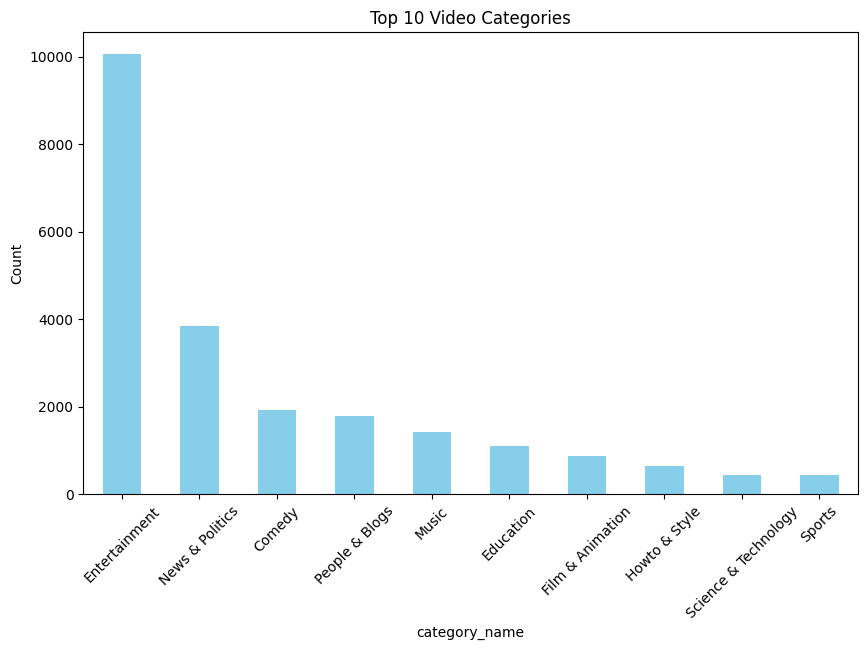

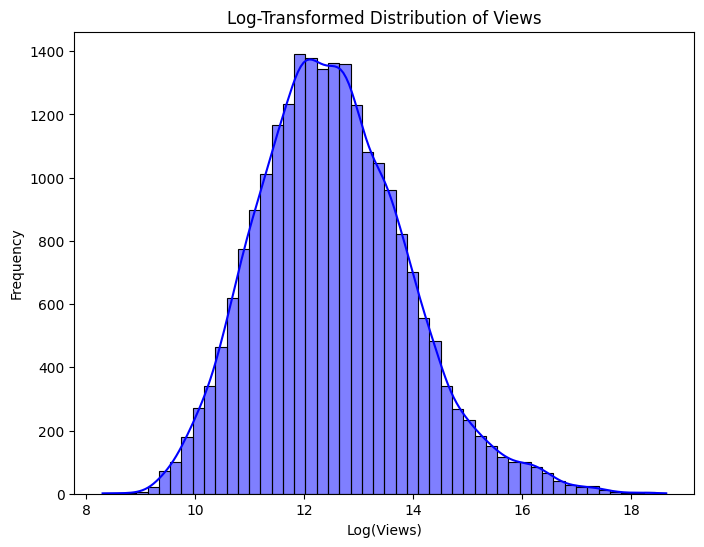

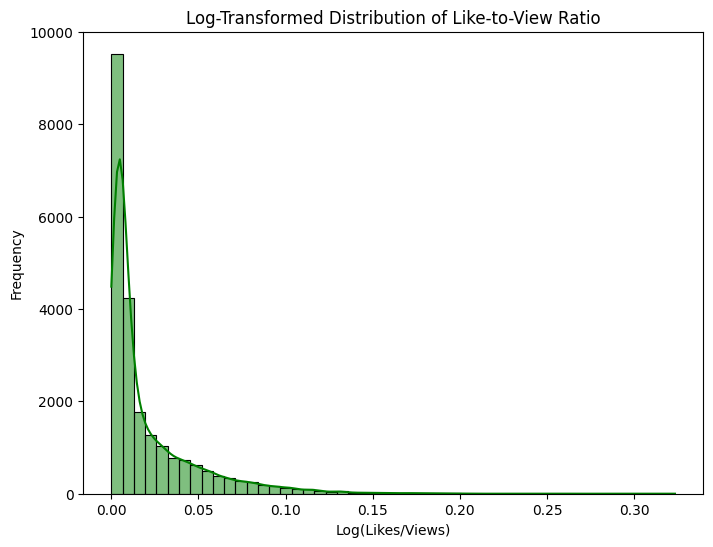

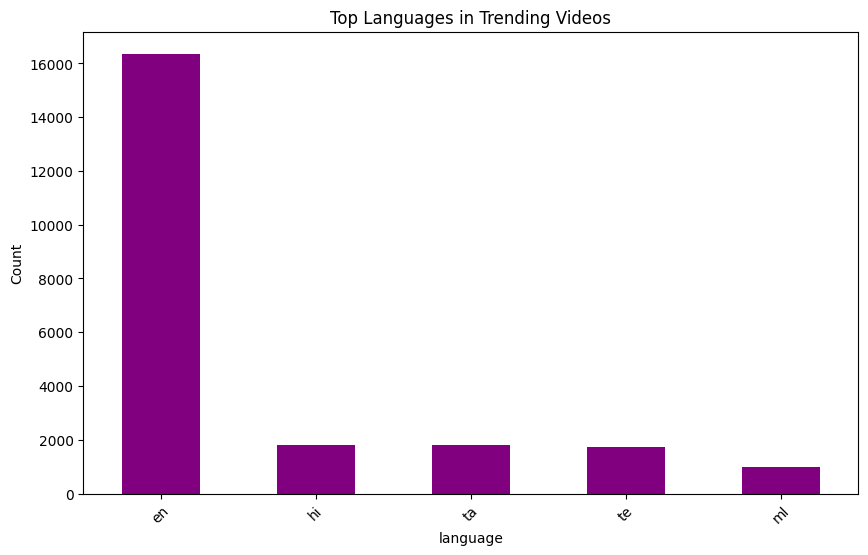

In [ ]:
# EDA on cleaned YouTube Trending dataset with fixes

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load cleaned dataset
df = pd.read_csv("youtube_trending_final_cleaned.csv")

# --- Fix Missing Categories ---
df["category_name"].fillna("Unknown", inplace=True)
print("Remaining missing categories:", df["category_name"].isnull().sum())

# --- Filter Languages ---

df = df[df['language'].isin(['en','hi','te','ta','ml'])]

# --- Basic Overview ---
print("Shape:", df.shape)
print("\nColumns:", df.columns)
print("\nMissing Values:\n", df.isnull().sum())

# --- Top 10 Categories ---
plt.figure(figsize=(10,6))
df['category_name'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Video Categories")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# --- Views Distribution ---
plt.figure(figsize=(8,6))
sns.histplot(np.log1p(df['views']), bins=50, kde=True, color="blue")
plt.title("Log-Transformed Distribution of Views")
plt.xlabel("Log(Views)")
plt.ylabel("Frequency")
plt.show()

# --- Like-to-View Ratio ---
df['like_view_ratio'] = df['likes'] / df['views']
plt.figure(figsize=(8,6))
sns.histplot(np.log1p(df['like_view_ratio']), bins=50, kde=True, color="green")
plt.title("Log-Transformed Distribution of Like-to-View Ratio")
plt.xlabel("Log(Likes/Views)")
plt.ylabel("Frequency")
plt.show()


# --- Language Breakdown ---
plt.figure(figsize=(10,6))
df['language'].value_counts().head(10).plot(kind='bar', color='purple')
plt.title("Top Languages in Trending Videos")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()



BY languages

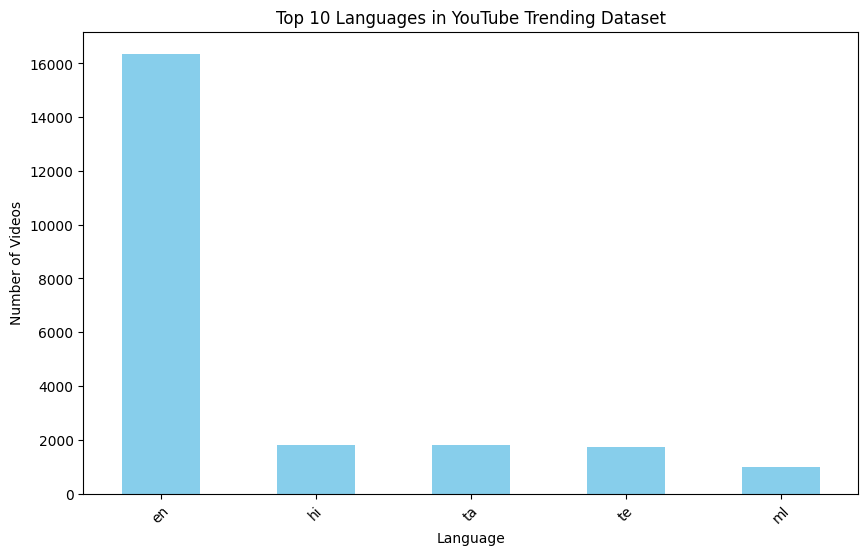

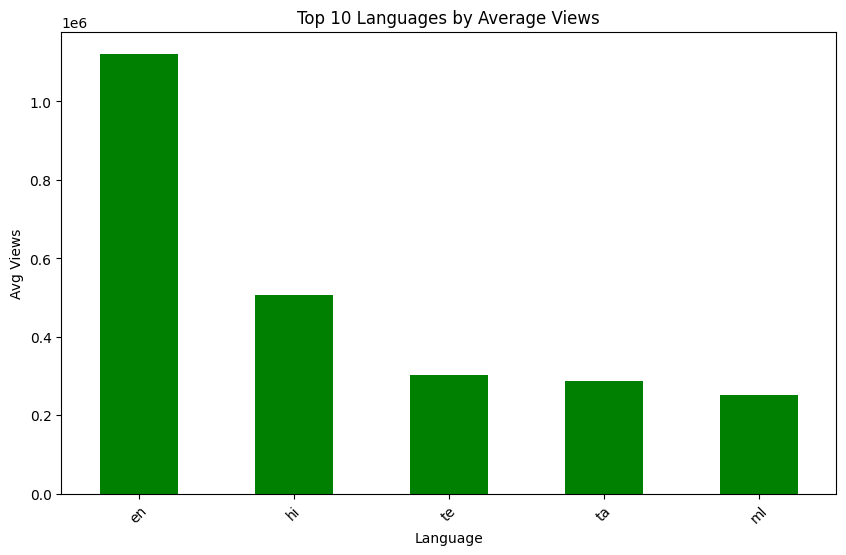

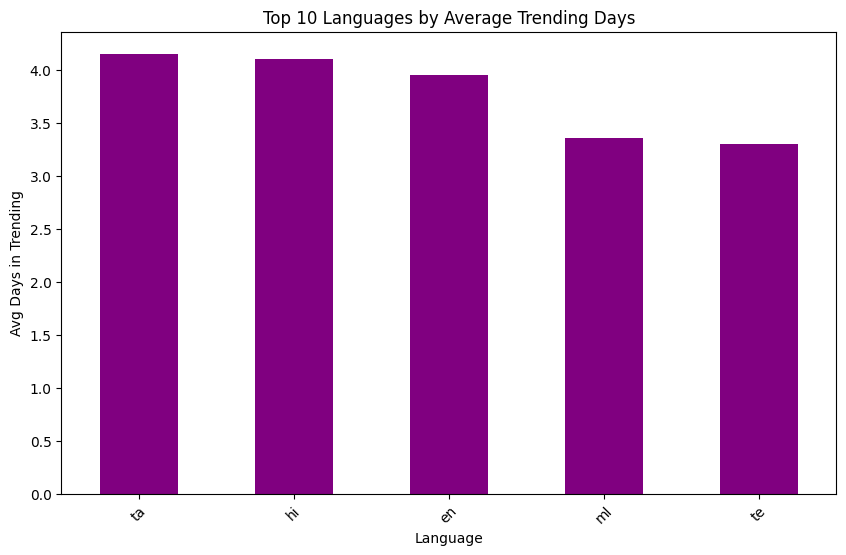

In [ ]:

# 1. Top Languages by Video Count

plt.figure(figsize=(10,6))
df["language"].value_counts().head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Languages in YouTube Trending Dataset")
plt.xlabel("Language")
plt.ylabel("Number of Videos")
plt.xticks(rotation=45)
plt.show()


# 2. Average Views by Language (Top 10 Only)

avg_views_lang = (
    df.groupby("language")["views"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(10,6))
avg_views_lang.plot(kind="bar", color="green")
plt.title("Top 10 Languages by Average Views")
plt.xlabel("Language")
plt.ylabel("Avg Views")
plt.xticks(rotation=45)
plt.show()

# 3. Average Days Trending by Language (Top 10 Only)

avg_days_lang = (
    df.groupby("language")["days_trending"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(10,6))
avg_days_lang.plot(kind="bar", color="purple")
plt.title("Top 10 Languages by Average Trending Days")
plt.xlabel("Language")
plt.ylabel("Avg Days in Trending")
plt.xticks(rotation=45)
plt.show()


Cross functionality

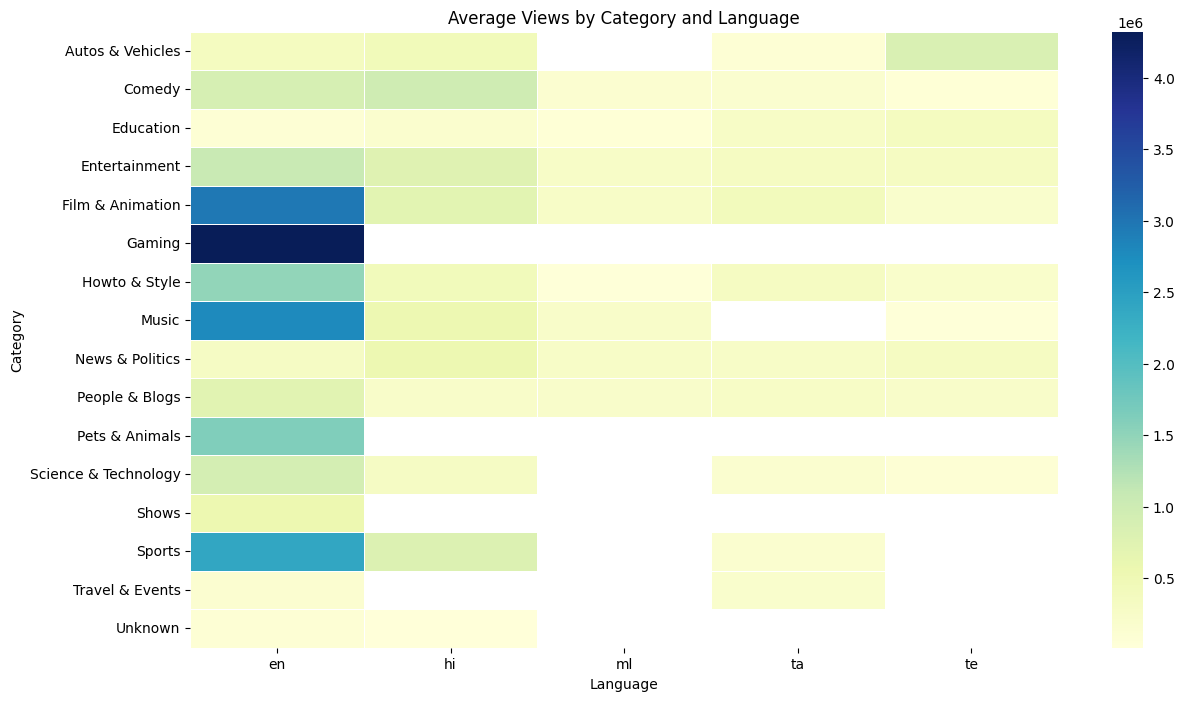

In [16]:
# ----------------------------
# Avg Views by Category & Language (Pandas)
# ----------------------------
heatmap_df = (
    df.groupby(["category_name", "language"])["views"]
      .mean()
      .reset_index()
)

# Pivot for heatmap
pivot_df = heatmap_df.pivot(index="category_name", columns="language", values="views")

plt.figure(figsize=(14,8))
sns.heatmap(pivot_df, cmap="YlGnBu", linewidths=0.5)
plt.title("Average Views by Category and Language")
plt.xlabel("Language")
plt.ylabel("Category")
plt.show()
